# Test the performance of the model

### Binary Quadratic Model

In [38]:
from quantum_computing_functions import *
from quantum_computing_postprocessing import *

from dwave.embedding.chain_strength import  uniform_torque_compensation
from dimod.binary import BinaryQuadraticModel
import numpy as np
import pandas as pd

from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.io.cif import CifWriter

from ase.visualize import view

import dataframe_image as dfi

import sys
sys.path.insert(1,'/Users/brunocamino/Desktop/Imperial/crystal-code-tools/crystal_functions/crystal_functions')
from file_readwrite import *
from convert import *
import re

In [39]:
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import copy
import numpy as np

lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

n_supercell = 3
scaling_matrix = np.identity(3)*n_supercell
scaling_matrix[2][2] = 1
graphene_supercell = copy.deepcopy(graphene)
graphene_supercell.make_supercell(scaling_matrix)
structure = graphene_supercell
graphene_supercell.num_sites



array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True])

# Loop

In [95]:
#for lagrange in [10,50,100,500,1000]:   
#for num_reads in [100,500,1000,1500,2000,2500]:   
for size in [3]:
    lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

    graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
    graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

    n_supercell = size
    scaling_matrix = np.identity(3)*n_supercell
    scaling_matrix[2][2] = 1
    graphene_supercell = copy.deepcopy(graphene)
    graphene_supercell.make_supercell(scaling_matrix)
    structure = graphene_supercell
    num_atoms = graphene_supercell.num_sites
    
    for ratio in [2]:
        for vac in [2]:
            structure = graphene_supercell
            use_coord = True
            num_vacancies= vac
            alpha = 1
            beta = 0.1
            lambda_1 =  1*ratio
            num_reads = 1000
            file_path = 'data/paper/'
            file_name = 'graphene'
            remove_broken_chains = False
            chain_strength = None

            bqm = build_quadratic_model(structure,use_coord=use_coord,alpha=alpha,beta=beta,
                                         lambda_1=lambda_1, num_vacancies=num_vacancies)

            chain_strength = uniform_torque_compensation(bqm,prefactor=0.3)

            #for chain_strength in [uniform_torque_compensation(bqm,prefactor=i) for i in np.arange(0.1,1.1,0.1)]:
            #for time in [1,2,5,10,20,50,100]:
            sampleset = run_anneal(bqm,dataframe = False, num_reads=num_reads, 
                                                       return_config_E=False,remove_broken_chains=remove_broken_chains,
                                      chain_strength=chain_strength)


                #save bqm
            save_json(structure,sampleset,bqm,use_coord=use_coord, num_vacancies=num_vacancies, 
              weight_1=alpha, weight_2=beta, lagrange=lambda_1, num_reads=num_reads,
              remove_broken_chains = remove_broken_chains,
              file_path=file_path, file_name=file_name, chain_strength=chain_strength)


Unconstrained quadratic model + contraints used


# Make structures - CRYSTAL

In [120]:
def make_structures(structure, array):
    structure_2 = copy.deepcopy(structure)
    structure_2.remove_sites(np.where(array == 0)[0])
    return structure_2

In [126]:
slurm_file_crystal = './data/crystal/slurm_file_crystal.slurm'

file = open(slurm_file_crystal, 'r')
slurm_file_crystal_data = file.readlines()
file.close()

# Adjacency matrix

In [142]:
A = build_adjacency_matrix(structure)
A_pd = pd.DataFrame(A)
#dfi.export(A_pd,'./data/images/adjacency_matrix.jpg')

# DF 0 vac

In [127]:
df_0v = load_json('./data/paper/graphene_C18_bqm_v0_cF_w11_w20_l1_r1000_t0_1663068004.json')[0]
df_0v['num_occurrences'] = [100]
df_0v = df_0v.rename(columns={"chain_break_fraction": "% broken chains", "energy": "Energy", "num_occurrences":"% occurence"})
df_0v.index = ['A']
display(df_0v)
dfi.export(df_0v,'./data/images/df_0v.jpg')

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,% broken chains,Energy,% occurence
A,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.0,-27.0,100


objc[54535]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x21afd9b50) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/107.0.5304.87/Libraries/libGLESv2.dylib (0x106a300d8). One of the two will be used. Which one is undefined.
[1103/172057.211328:INFO:headless_shell.cc(657)] Written to file /var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/tmpnh5sgn9m/temp.png.


In [128]:
crystal_input = Crystal_input().from_file('./data/paper/crystal/graphene.d12')
df = df_0v
for i in df.index:
    array = df.loc[i].to_numpy()[0:18]
    structure_tmp = make_structures(structure,array)
    vac = structure_tmp.num_sites-structure.num_sites
    structure_gui = cry_pmg2gui(structure_tmp,symmetry=False,dimensionality=2)
    name = 'graphene_%sv_%s'%(str(vac),i)
    structure_gui.write_crystal_gui('./data/paper/crystal/%s.gui'%name,symm=False)
    crystal_input.write_crystal_input('./data/paper/crystal/%s.d12'%name) 
    
    slurm_file_crystal_data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm %s &\n'%name)
    slurm_file_crystal_data.append('wait\n')
    slurm_file_crystal_data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm crys %s &\n'%name)
    slurm_file_crystal_data.append('wait\n\n')
    slurm_file_crystal_data.append('')

### THE FUNCTION

In [161]:
def make_df_paper(dataframe,num_vacancies,symmetrised=False,structure=None,num_runs=1):
    
    import copy
    import string
    
    df = dataframe
    
    num_atoms = sum([x.isdigit() for x in df.columns])        
    all_config = df.iloc[:,0:num_atoms].to_numpy()
    multiplicity = df['num_occurrences'].to_numpy()
    sum_vector = np.sum(all_config,axis=1)
    feasible_config = np.where(np.round(sum_vector,5) == np.round((num_atoms - num_vacancies),5))[0]
    config =  np.array(df.iloc[feasible_config].to_numpy()[:,0:num_atoms],dtype=int)
    chain_break = np.array(df.iloc[feasible_config].to_numpy()[:,num_atoms])
    unique_config = np.unique(config,axis=0)

    chain_break_average = []
    energy_average = []
    num_occurences_average = []
    for c in unique_config:
        chain_break_average.append(np.average(df.iloc[feasible_config[np.where((config == c).all(axis=1))[0]]]['chain_break_fraction'].to_numpy()))
        energy_average.append(np.average(df.iloc[feasible_config[np.where((config == c).all(axis=1))[0]]]['energy'].to_numpy()))
        num_occurences_average.append(np.sum(df.iloc[feasible_config[np.where((config == c).all(axis=1))[0]]]['num_occurrences'].to_numpy())/(num_runs))
    chain_break_average

    df = pd.DataFrame(unique_config, columns=[str(x) for x in np.arange(num_atoms,dtype=int)])
    df['chain_break_fraction'] = np.round(chain_break_average,3)
    df['energy'] = energy_average
    df['num_occurrences'] = num_occurences_average
    
     
    if symmetrised == True and structure != None:
        
        structure_tmp = copy.deepcopy(structure)
        #df = find_symmetry_equivalent_structures(df[df['energy'] == -24.],structure_tmp)
        df = find_symmetry_equivalent_structures(df,structure_tmp)

    df['chain_break_fraction'] = np.round(df['chain_break_fraction'].to_numpy(),5)
    df['chain_break_fraction'] = df['chain_break_fraction'].apply(lambda x: x*100)
    df['num_occurrences'] = df['num_occurrences'].apply(lambda x: x/10)
    df = df.rename(columns={"chain_break_fraction": "% broken chains", "energy": "Energy", "num_occurrences":"% occurence"})
    df.index = list(string.ascii_uppercase[0:len(df.index)])
    
    return df

# DF 1 vac

In [162]:
dataframe = load_json('./data/paper/graphene_C18_bqm_v1_cF_w11_w20_l2_r1000_t0_1666191205.json')[0]
make_df_paper(dataframe,num_vacancies=1,symmetrised=True,structure=graphene_supercell,num_runs=1)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,% broken chains,Energy,% occurence
A,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1.383,-24.0,67.0


In [144]:
df_1v = load_json('./data/paper/graphene_C18_bqm_v1_cF_w11_w20_l2_r1000_t0_1666191205.json')[0]
df = df_1v
num_runs = 1
num_vacancies = 1
num_atoms = sum([x.isdigit() for x in df.columns])
        
all_config = df.iloc[:,0:num_atoms].to_numpy()

multiplicity = df['num_occurrences'].to_numpy()

sum_vector = np.sum(all_config,axis=1)

feasible_config = np.where(np.round(sum_vector,5) == np.round((num_atoms - num_vacancies),5))[0]

config =  np.array(df.iloc[feasible_config].to_numpy()[:,0:num_atoms],dtype=int)

chain_break = np.array(df.iloc[feasible_config].to_numpy()[:,num_atoms])

unique_config = np.unique(config,axis=0)

chain_break_average = []
energy_average = []
num_occurences_average = []
for c in unique_config:
    chain_break_average.append(np.average(df.iloc[feasible_config[np.where((config == c).all(axis=1))[0]]]['chain_break_fraction'].to_numpy())*100)
    energy_average.append(np.average(df.iloc[feasible_config[np.where((config == c).all(axis=1))[0]]]['energy'].to_numpy()))
    num_occurences_average.append(np.sum(df.iloc[feasible_config[np.where((config == c).all(axis=1))[0]]]['num_occurrences'].to_numpy())/(num_runs*10))
chain_break_average

df_1v = pd.DataFrame(unique_config, columns=[str(x) for x in np.arange(18,dtype=int)])
df_1v['chain_break_fraction'] = np.round(chain_break_average,3)
df_1v['energy'] = energy_average
df_1v['num_occurrences'] = num_occurences_average
#print(df_1v_new2.style.to_latex(column_format='|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|'))
df_1v

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,chain_break_fraction,energy,num_occurrences
0,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,2.778,-24.0,5.2
1,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.000,-24.0,3.1
2,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.000,-24.0,2.9
3,1,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,3.704,-24.0,5.0
4,1,1,1,1,0,1,1,1,1,1,...,1,1,1,1,1,1,1,2.778,-24.0,2.5
5,1,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,0.000,-24.0,3.8
6,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,0.000,-24.0,2.8
7,1,1,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,4.444,-24.0,5.3
8,1,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,2.778,-24.0,4.8
9,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,0.000,-24.0,3.3


In [144]:
df_1v = load_json('./data/paper/graphene_C18_bqm_v1_cF_w11_w20_l2_r1000_t0_1666191205.json')[0]
df = df_1v
num_runs = 1
num_vacancies = 1
num_atoms = sum([x.isdigit() for x in df.columns])
        
all_config = df.iloc[:,0:num_atoms].to_numpy()

multiplicity = df['num_occurrences'].to_numpy()

sum_vector = np.sum(all_config,axis=1)

feasible_config = np.where(np.round(sum_vector,5) == np.round((num_atoms - num_vacancies),5))[0]

config =  np.array(df.iloc[feasible_config].to_numpy()[:,0:num_atoms],dtype=int)

chain_break = np.array(df.iloc[feasible_config].to_numpy()[:,num_atoms])

unique_config = np.unique(config,axis=0)

chain_break_average = []
energy_average = []
num_occurences_average = []
for c in unique_config:
    chain_break_average.append(np.average(df.iloc[feasible_config[np.where((config == c).all(axis=1))[0]]]['chain_break_fraction'].to_numpy())*100)
    energy_average.append(np.average(df.iloc[feasible_config[np.where((config == c).all(axis=1))[0]]]['energy'].to_numpy()))
    num_occurences_average.append(np.sum(df.iloc[feasible_config[np.where((config == c).all(axis=1))[0]]]['num_occurrences'].to_numpy())/(num_runs*10))
chain_break_average

df_1v = pd.DataFrame(unique_config, columns=[str(x) for x in np.arange(18,dtype=int)])
df_1v['chain_break_fraction'] = np.round(chain_break_average,3)
df_1v['energy'] = energy_average
df_1v['num_occurrences'] = num_occurences_average
#print(df_1v_new2.style.to_latex(column_format='|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|'))
df_1v

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,chain_break_fraction,energy,num_occurrences
0,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,2.778,-24.0,5.2
1,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.000,-24.0,3.1
2,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.000,-24.0,2.9
3,1,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,3.704,-24.0,5.0
4,1,1,1,1,0,1,1,1,1,1,...,1,1,1,1,1,1,1,2.778,-24.0,2.5
5,1,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,0.000,-24.0,3.8
6,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,0.000,-24.0,2.8
7,1,1,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,4.444,-24.0,5.3
8,1,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,2.778,-24.0,4.8
9,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,0.000,-24.0,3.3


In [131]:
df_1v_new2 = df_1v_new2.rename(columns={"chain_break_fraction": "% broken chains", "energy": "Energy", "num_occurrences":"% occurence"})
#display(df_1v_new2)
dfi.export(df_1v_new2,'./data/images/df_1v.jpg')

objc[54604]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x21afd9b50) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/107.0.5304.87/Libraries/libGLESv2.dylib (0x1089840d8). One of the two will be used. Which one is undefined.
[1103/172157.276395:INFO:headless_shell.cc(657)] Written to file /var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/tmprrj2zbll/temp.png.


## DF 1 vac symmetry reduced

In [132]:
import copy
dataframe = load_json('./data/paper/graphene_C18_bqm_v1_cF_w11_w20_l2_r1000_t0_1666191205.json')[0]
structure = copy.deepcopy(graphene_supercell)
df_1v = find_symmetry_equivalent_structures(dataframe[dataframe['energy'] == -24.],structure)
df_1v['chain_break_fraction'] = df_1v['chain_break_fraction'].apply(lambda x: x*100)
df_1v['num_occurrences'] = df_1v['num_occurrences'].apply(lambda x: x/10)
#print(df_1v[df_1v['energy'] == -24.].style.to_latex())

df_1v = df_1v.rename(columns={"chain_break_fraction": "% broken chains", "energy": "Energy", "num_occurrences":"% occurence"})
df_1v.index=['A']
display(df_1v)

dfi.export(df_1v,'./data/images/df_1v_symm.jpg')

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,% broken chains,Energy,% occurence
A,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,2.222222,-24.0,67.0


objc[54623]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x21afd9b50) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/107.0.5304.87/Libraries/libGLESv2.dylib (0x1085b40d8). One of the two will be used. Which one is undefined.
[1103/172200.616975:INFO:headless_shell.cc(657)] Written to file /var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/tmpn_sw12fu/temp.png.


In [133]:
crystal_input = Crystal_input().from_file('./data/paper/crystal/graphene.d12')
df = df_1v
for i in df.index:
    print(i)
    array = df.loc[i].to_numpy()[0:18]
    structure_tmp = make_structures(structure,array)
    vac = structure.num_sites - structure_tmp.num_sites
    structure_gui = cry_pmg2gui(structure_tmp,symmetry=False,dimensionality=2)
    name = 'graphene_%sv_%s'%(str(vac),i)
    structure_gui.write_crystal_gui('./data/paper/crystal/%s.gui'%name,symm=False)
    crystal_input.write_crystal_input('./data/paper/crystal/%s.d12'%name)
    slurm_file_crystal_data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm %s &\n'%name)
    slurm_file_crystal_data.append('wait\n')
    slurm_file_crystal_data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm crys %s &\n'%name)
    slurm_file_crystal_data.append('wait\n\n')
    slurm_file_crystal_data.append('')

A


# DF 2 vac

In [119]:
df_2v_new = load_json('./data/paper/graphene_C18_bqm_v2_cF_w11_w20_l2_r1000_t0_1663860866.json')[0]
df = df_2v_new
num_vacancies = 2
num_atoms = sum([x.isdigit() for x in df.columns])
        
all_config = df.iloc[:,0:num_atoms].to_numpy()

multiplicity = df['num_occurrences'].to_numpy()

sum_vector = np.sum(all_config,axis=1)

feasible_config = np.where(np.round(sum_vector,5) == np.round((num_atoms - num_vacancies),5))[0]
feasible_config = feasible_config

config =  np.array(df.iloc[feasible_config].to_numpy()[:,0:num_atoms],dtype=int)

chain_break = np.array(df.iloc[feasible_config].to_numpy()[:,num_atoms])

unique_config = np.unique(config,axis=0)

chain_break_average = []
energy_average = []
num_occurences_average = []
for c in unique_config:
    #print(c)
    #print(df_1v_new.iloc[feasible_config[np.where((config == c).all(axis=1))[0]]])
    chain_break_average.append(np.average(df_2v_new.iloc[feasible_config[np.where((config == c).all(axis=1))[0]]]['chain_break_fraction'].to_numpy()))
    energy_average.append(np.average(df_2v_new.iloc[feasible_config[np.where((config == c).all(axis=1))[0]]]['energy'].to_numpy()))
    num_occurences_average.append(np.sum(df_2v_new.iloc[feasible_config[np.where((config == c).all(axis=1))[0]]]['num_occurrences'].to_numpy()))
chain_break_average

df_2v_new2 = pd.DataFrame(unique_config, columns=[str(x) for x in np.arange(18,dtype=int)])
df_2v_new2['chain_break_fraction'] = np.round(chain_break_average,3)
df_2v_new2['energy'] = energy_average
df_2v_new2['num_occurrences'] = num_occurences_average
df_2v_new2

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,chain_break_fraction,energy,num_occurrences
0,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.000,-21.0,3
1,0,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.000,-21.0,4
2,0,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.000,-21.0,4
3,0,1,1,1,0,1,1,1,1,1,...,1,1,1,1,1,1,1,0.000,-21.0,2
4,0,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,0.000,-21.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,0,1,1,0.000,-21.0,3
141,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,1,0,1,0.000,-21.0,2
142,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,0,1,0.000,-21.0,2
143,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,0,0.000,-21.0,1


In [82]:
#dataframe = load_json('./data/paper/graphene_C18_bqm_v3_cF_w11_w20_l2_r1000_t0_1663870143.json')[0]
df = df_2v_new2

structure = copy.deepcopy(graphene_supercell)
df = find_symmetry_equivalent_structures(dataframe,structure,vacancies=2)

df.sort_values(by=['energy'], inplace=True)
df['chain_break_fraction'] = df['chain_break_fraction'].apply(lambda x: x*100)
df['num_occurrences'] = df['num_occurrences'].apply(lambda x: x/10)
df = df.rename(columns={"chain_break_fraction": "% broken chains", "energy": "Energy", "num_occurrences":"% occurence"})
df.index=['A','B','C','D','E']
df_2v = df
dfi.export(df,'./data/images/df_2v_symm.jpg')

objc[53344]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x21afd9b50) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/107.0.5304.87/Libraries/libGLESv2.dylib (0x105bc40d8). One of the two will be used. Which one is undefined.
[1103/164414.873849:INFO:headless_shell.cc(657)] Written to file /var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/tmplj0okd95/temp.png.


In [83]:
pd.concat([df_0v,df_1v,df_2v])

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,% broken chains,Energy,% occurence
A,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.000000,-27.0,100.0
A,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,2.222222,-24.0,67.0
A,1,1,1,1,1,0,1,1,1,1,...,0,1,1,1,1,1,1,0.284900,-20.0,75.0
B,1,1,1,1,1,1,1,1,1,1,...,0,1,0,1,1,1,1,0.793651,-19.0,3.6
C,1,1,1,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,0.000000,-19.0,10.7
D,0,1,1,1,1,1,1,1,1,1,...,1,1,1,0,1,1,1,0.000000,-19.0,3.9
E,1,1,1,1,1,1,1,0,1,1,...,0,1,1,1,1,1,1,1.010101,-19.0,2.0


In [20]:
crystal_input = Crystal_input().from_file('./data/paper/crystal/graphene.d12')
df = df
for i in df.index:
    print(i)
    array = df.loc[i].to_numpy()[0:18]
    structure_tmp = make_structures(structure,array)
    vac = structure.num_sites - structure_tmp.num_sites
    structure_gui = cry_pmg2gui(structure_tmp,symmetry=False)
    name = 'graphene_%sv_%s'%(str(vac),i)
    structure_gui.write_crystal_gui('./data/paper/crystal/%s.gui'%name,symm=False)
    crystal_input.write_crystal_input('./data/paper/crystal/%s.d12'%name)
    slurm_file_crystal_data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm %s &\n'%name)
    slurm_file_crystal_data.append('wait\n')
    slurm_file_crystal_data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm crys %s &\n'%name)
    slurm_file_crystal_data.append('wait\n\n')
    slurm_file_crystal_data.append('')

A


NameError: name 'make_structures' is not defined

# DF 3 vac

In [21]:
df_3v_new = load_json('./data/paper/graphene_C18_bqm_v3_cF_w11_w20_l2_r1000_t0_1663870143.json')[0]
df = df_3v_new
num_vacancies = 3
num_atoms = sum([x.isdigit() for x in df.columns])
        
all_config = df.iloc[:,0:num_atoms].to_numpy()

multiplicity = df['num_occurrences'].to_numpy()

sum_vector = np.sum(all_config,axis=1)

feasible_config = np.where(np.round(sum_vector,5) == np.round((num_atoms - num_vacancies),5))[0]
feasible_config = feasible_config

config =  np.array(df.iloc[feasible_config].to_numpy()[:,0:num_atoms],dtype=int)

chain_break = np.array(df.iloc[feasible_config].to_numpy()[:,num_atoms])

unique_config = np.unique(config,axis=0)

chain_break_average = []
energy_average = []
num_occurences_average = []
for c in unique_config:
    #print(c)
    #print(df_1v_new.iloc[feasible_config[np.where((config == c).all(axis=1))[0]]])
    chain_break_average.append(np.average(df.iloc[feasible_config[np.where((config == c).all(axis=1))[0]]]['chain_break_fraction'].to_numpy()))
    energy_average.append(np.average(df.iloc[feasible_config[np.where((config == c).all(axis=1))[0]]]['energy'].to_numpy()))
    num_occurences_average.append(np.sum(df.iloc[feasible_config[np.where((config == c).all(axis=1))[0]]]['num_occurrences'].to_numpy()))
chain_break_average

df_3v_new2 = pd.DataFrame(unique_config, columns=[str(x) for x in np.arange(18,dtype=int)])
df_3v_new2['chain_break_fraction'] = np.round(chain_break_average,3)
df_3v_new2['energy'] = energy_average
df_3v_new2['num_occurrences'] = num_occurences_average
#print(df_2v_new2.style.to_latex(column_format='|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|'))
df_3v_new2

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,chain_break_fraction,energy,num_occurrences
0,0,0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.000,-18.0,1
1,0,0,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,0.000,-18.0,1
2,0,0,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,0.000,-18.0,1
3,0,0,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,0.028,-19.0,3
4,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.000,-20.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,1,1,1,1,1,1,1,1,1,1,...,1,0,1,0,1,1,0,0.056,-18.0,3
354,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,0,0,0.028,-18.0,2
355,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,0,0,1,0.056,-18.0,1
356,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,0,0,0.000,-18.0,1


In [22]:
dataframe = df_3v_new2

structure = copy.deepcopy(graphene_supercell)
df = find_symmetry_equivalent_structures(dataframe,structure,vacancies=3)
df_3v = df
df.sort_values(by=['energy'], inplace=True)
df['chain_break_fraction'] = df['chain_break_fraction'].apply(lambda x: x*100)
df['num_occurrences'] = df['num_occurrences'].apply(lambda x: x/10)
df = df.rename(columns={"chain_break_fraction": "% broken chains", "energy": "Energy", "num_occurrences":"% occurence"})
df.index=['A','B','C','D','E','F','G','H','I','J','K','L','M','N']
dfi.export(df,'./data/images/df_3v_coord_symm.jpg')
df_non_coord = copy.deepcopy(df)
df_non_coord

objc[8854]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x21afd9b50) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/107.0.5304.87/Libraries/libGLESv2.dylib (0x1084a80d8). One of the two will be used. Which one is undefined.
[1102/182532.896858:INFO:headless_shell.cc(657)] Written to file /var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/tmpl3ult4ru/temp.png.


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,% broken chains,Energy,% occurence
A,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1.162295,-20.0,13.2
B,0,0,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,0.698333,-19.0,9.9
C,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1.056604,-19.0,7.5
D,0,1,1,1,1,0,1,1,1,0,...,1,1,1,1,1,1,1,2.115152,-19.0,6.2
E,0,1,1,1,1,1,1,0,1,0,...,1,1,1,1,1,1,1,0.254545,-19.0,3.6
F,0,0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,2.177778,-18.0,1.1
G,0,0,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1.960000,-18.0,1.2
H,0,0,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1.264516,-18.0,5.7
I,0,0,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,2.000000,-18.0,4.3
J,0,1,0,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.000000,-18.0,0.2


In [32]:
crystal_input = Crystal_input().from_file('./data/paper/crystal/graphene.d12')
df = df
for i in df.index:
    array = df.loc[i].to_numpy()[0:18]
    structure_tmp = make_structures(structure,array)
    vac = structure.num_sites - structure_tmp.num_sites
    structure_gui = cry_pmg2gui(structure_tmp,symmetry=False)
    name = 'graphene_%sv_%s'%(str(vac),i)
    structure_gui.write_crystal_gui('./data/paper/crystal/%s.gui'%name,symm=False)
    crystal_input.write_crystal_input('./data/paper/crystal/%s.d12'%name)
    slurm_file_crystal_data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm %s &\n'%name)
    slurm_file_crystal_data.append('wait\n')
    slurm_file_crystal_data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm crys %s &\n'%name)
    slurm_file_crystal_data.append('wait\n\n')
    slurm_file_crystal_data.append('')

A
B
C
D
E
F
G
H
I
J
K
L
M
N


In [206]:
#For consistency
for i in [str(x) for x in range(18)]:
    df_non_coord[i] = df_coord[i]

In [140]:
with open('./data/paper/crystal/crystal_slurm', 'w') as file:
    for line in slurm_file_crystal_data:
        file.writelines(line)

# Add coordination

# DF 2 vac

In [134]:
df_2v_new = load_json('./data/paper/graphene_C18_bqm_v2_cT_w11_w20.05_l2_r1000_t0_1667490895.json')[0]
df = df_2v_new
num_vacancies = 2
num_atoms = sum([x.isdigit() for x in df.columns])
        
all_config = df.iloc[:,0:num_atoms].to_numpy()

multiplicity = df['num_occurrences'].to_numpy()

sum_vector = np.sum(all_config,axis=1)

feasible_config = np.where(np.round(sum_vector,5) == np.round((num_atoms - num_vacancies),5))[0]
feasible_config = feasible_config

config =  np.array(df.iloc[feasible_config].to_numpy()[:,0:num_atoms],dtype=int)

chain_break = np.array(df.iloc[feasible_config].to_numpy()[:,num_atoms])

unique_config = np.unique(config,axis=0)

chain_break_average = []
energy_average = []
num_occurences_average = []
for c in unique_config:
    #print(c)
    #print(df_1v_new.iloc[feasible_config[np.where((config == c).all(axis=1))[0]]])
    chain_break_average.append(np.average(df.iloc[feasible_config[np.where((config == c).all(axis=1))[0]]]['chain_break_fraction'].to_numpy()))
    energy_average.append(np.average(df.iloc[feasible_config[np.where((config == c).all(axis=1))[0]]]['energy'].to_numpy()))
    num_occurences_average.append(np.sum(df.iloc[feasible_config[np.where((config == c).all(axis=1))[0]]]['num_occurrences'].to_numpy()))
chain_break_average

df_2v_new2 = pd.DataFrame(unique_config, columns=[str(x) for x in np.arange(18,dtype=int)])
df_2v_new2['chain_break_fraction'] = np.round(chain_break_average,3)
df_2v_new2['energy'] = energy_average
df_2v_new2['num_occurrences'] = num_occurences_average
#print(df_2v_new2.style.to_latex(column_format='|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|'))
df_2v_new2

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,chain_break_fraction,energy,num_occurrences
0,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.028,-18.85,8
1,0,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.000,-18.85,1
2,0,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.028,-18.85,4
3,0,1,1,1,0,1,1,1,1,1,...,1,1,1,1,1,1,1,0.028,-18.85,4
4,0,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,0.074,-18.90,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,1,0,1,0.056,-18.90,9
142,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,1,1,0,0.000,-18.85,3
143,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,0,1,0.028,-18.85,10
144,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,0,0.000,-18.85,8


In [135]:
df = df_2v_new2

structure = copy.deepcopy(graphene_supercell)
df = find_symmetry_equivalent_structures(df,structure,vacancies=2)

df.sort_values(by=['energy'], inplace=True)
df['chain_break_fraction'] = df['chain_break_fraction'].apply(lambda x: x*100)
df['num_occurrences'] = df['num_occurrences'].apply(lambda x: x/10)
df = df.rename(columns={"chain_break_fraction": "% broken chains", "energy": "Energy", "num_occurrences":"% occurence"})
df.index=['A','B','C','D','E']
df_2v = df
#dfi.export(df,'./data/images/df_2v_symm.jpg')

In [136]:
crystal_input = Crystal_input().from_file('./data/paper/crystal/graphene.d12')
df = df
for i in df.index:
    array = df.loc[i].to_numpy()[0:18]
    structure_tmp = make_structures(structure,array)
    vac = structure.num_sites - structure_tmp.num_sites
    structure_gui = cry_pmg2gui(structure_tmp,symmetry=False,dimensionality=2)
    name = 'graphene_%sv_%s'%(str(vac),i)
    structure_gui.write_crystal_gui('./data/paper/crystal/%s.gui'%name,symm=False)
    crystal_input.write_crystal_input('./data/paper/crystal/%s.d12'%name)
    slurm_file_crystal_data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm %s &\n'%name)
    slurm_file_crystal_data.append('wait\n')
    slurm_file_crystal_data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm crys %s &\n'%name)
    slurm_file_crystal_data.append('wait\n\n')
    slurm_file_crystal_data.append('')

# DF 3 vac

In [137]:
df_3v_new = load_json('./data/paper/graphene_C18_bqm_v3_cT_w11_w20.05_l2_r1000_t0_1666361376.json')[0]
df = df_3v_new
num_vacancies = 3
num_atoms = sum([x.isdigit() for x in df.columns])
        
all_config = df.iloc[:,0:num_atoms].to_numpy()

multiplicity = df['num_occurrences'].to_numpy()

sum_vector = np.sum(all_config,axis=1)

feasible_config = np.where(np.round(sum_vector,5) == np.round((num_atoms - num_vacancies),5))[0]
feasible_config = feasible_config

config =  np.array(df.iloc[feasible_config].to_numpy()[:,0:num_atoms],dtype=int)

chain_break = np.array(df.iloc[feasible_config].to_numpy()[:,num_atoms])

unique_config = np.unique(config,axis=0)

chain_break_average = []
energy_average = []
num_occurences_average = []
for c in unique_config:
    #print(c)
    #print(df_1v_new.iloc[feasible_config[np.where((config == c).all(axis=1))[0]]])
    chain_break_average.append(np.average(df.iloc[feasible_config[np.where((config == c).all(axis=1))[0]]]['chain_break_fraction'].to_numpy()))
    energy_average.append(np.average(df.iloc[feasible_config[np.where((config == c).all(axis=1))[0]]]['energy'].to_numpy()))
    num_occurences_average.append(np.sum(df.iloc[feasible_config[np.where((config == c).all(axis=1))[0]]]['num_occurrences'].to_numpy()))
chain_break_average

df_3v_new2 = pd.DataFrame(unique_config, columns=[str(x) for x in np.arange(18,dtype=int)])
df_3v_new2['chain_break_fraction'] = np.round(chain_break_average,3)
df_3v_new2['energy'] = energy_average
df_3v_new2['num_occurrences'] = num_occurences_average
#print(df_2v_new2.style.to_latex(column_format='|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|'))
df_3v_new2

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,chain_break_fraction,energy,num_occurrences
0,0,0,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.000,-16.10,1
1,0,0,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,0.000,-17.15,1
2,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,0.000,-17.15,1
3,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,0.000,-17.15,1
4,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,0.000,-16.15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,0,0,0.000,-16.10,1
328,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,1,0,1,0.000,-16.10,2
329,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,0,1,0,0.000,-16.10,1
330,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,0,0,1,0.056,-16.10,1


In [138]:
dataframe = df_3v_new2
structure = copy.deepcopy(graphene_supercell)
df = find_symmetry_equivalent_structures(dataframe,structure,vacancies=3)
df_3v_coord = df
df.sort_values(by=['energy'], inplace=True)
df['chain_break_fraction'] = df['chain_break_fraction'].apply(lambda x: x*100)
df['num_occurrences'] = df['num_occurrences'].apply(lambda x: x/10)
df = df.rename(columns={"chain_break_fraction": "% broken chains", "energy": "Energy", "num_occurrences":"% occurence"})
df.index=['A','B','C','D','E','F','G','H','I','J','K','L','M','N']
dfi.export(df,'./data/images/df_3v_coord_symm.jpg')
df_coord = copy.deepcopy(df)
df_coord

objc[54735]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x21afd9b50) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/107.0.5304.87/Libraries/libGLESv2.dylib (0x10a2c00d8). One of the two will be used. Which one is undefined.
[1103/172334.665635:INFO:headless_shell.cc(657)] Written to file /var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/tmpd1s12ag4/temp.png.


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,% broken chains,Energy,% occurence
A,0,1,1,0,1,1,1,1,1,0,...,1,1,1,1,1,1,1,0.602941,-18.15,6.7
B,0,1,1,1,1,1,1,0,1,1,...,1,1,1,1,0,1,1,0.393939,-17.20,5.2
C,0,1,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,0,0.560000,-17.20,2.3
D,0,0,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1.142857,-17.15,15.4
E,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1.186207,-17.15,11.9
F,0,1,1,1,1,0,1,0,1,1,...,1,1,1,1,1,1,1,0.000000,-16.20,0.2
G,0,1,1,1,1,1,1,0,1,1,...,0,1,1,1,1,1,1,1.900000,-16.20,3.0
H,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1.687500,-16.15,3.1
I,0,1,0,1,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1.403448,-16.15,6.4
J,1,0,1,1,1,1,1,0,1,0,...,1,1,1,1,1,1,1,2.230000,-16.15,1.4


In [139]:
crystal_input = Crystal_input().from_file('./data/paper/crystal/graphene.d12')
df = df
for i in df.index:
    array = df.loc[i].to_numpy()[0:18]
    structure_tmp = make_structures(structure,array)
    vac = structure.num_sites - structure_tmp.num_sites
    structure_gui = cry_pmg2gui(structure_tmp,symmetry=False,dimensionality=2)
    name = 'graphene_%sv_%s'%(str(vac),i)
    structure_gui.write_crystal_gui('./data/paper/crystal/%s.gui'%name,symm=False)
    crystal_input.write_crystal_input('./data/paper/crystal/%s.d12'%name)
    slurm_file_crystal_data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm %s &\n'%name)
    slurm_file_crystal_data.append('wait\n')
    slurm_file_crystal_data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm crys %s &\n'%name)
    slurm_file_crystal_data.append('wait\n\n')
    slurm_file_crystal_data.append('')

In [40]:
def make_df(directory):

    import os

    dataframes = []

    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        if os.path.isfile(f) and f.endswith(".json") and 'bqm' in f:
            #print(f)
            df, param = load_json(f,return_param = True, return_qubo = False)        
            param = param.transpose()
            n_vac = param['num_vacancies'].values[0]
            n_atoms = param['N atoms'].values[0]
            param['broken_chains'] = find_ratio_broken_chains(df)   
            param['ratio_feasible'] = find_ratio_feasible(df,param['num_vacancies'].values[0], remove_broken_chains=False)
            param['ratio_gs'] = find_ratio_ground_state(df,param['num_vacancies'].values[0], remove_broken_chains=False)
            param['energy_distribution_all'] = ', '.join(str(x) for x in find_energy_distribution(df)[0])
            param['multiplicity_all'] = ', '.join(str(x) for x in find_energy_distribution(df)[1])        
            param['energy_distribution'] = ', '.join(str(x) for x in find_energy_distribution(df, only_feasible=True, vacancies=param['num_vacancies'].values[0])[0])
            #param['num_broken_bonds'] = ', '.join(str(x) for x in find_num_broken_bonds(dataframe, remove_broken_chains = True, only_feasible = True, vacancies = param['num_vacancies'].values[0]))
            param['multiplicity'] = ', '.join(str(x) for x in find_energy_distribution(df, only_feasible=True, vacancies=param['num_vacancies'].values[0])[1])
            param['ratio l/w'] =  param['lagrange'] / param['weight_1'] 
            param['vacancies'] = ', '.join(str(x) for x in find_vacancy_distribution(df)[0])
            param['vacancies mult'] = ', '.join(str(x) for x in find_vacancy_distribution(df)[1])
            
            if 'chain_strength' not in param:
                param['chain_strength'] = -1
            #print(param['chain_strength'])
            if param['chain_strength'].all() == None:
                param['chain_strength'] = -1
            dataframes.append(param)

    df_results = pd.concat(dataframes)
    
    return df_results

## $\alpha$ , $\gamma$ ratio

### weight_1 = 1

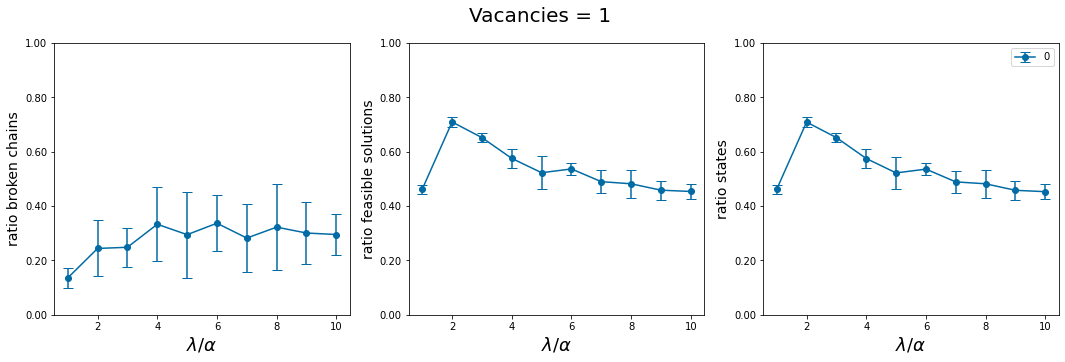

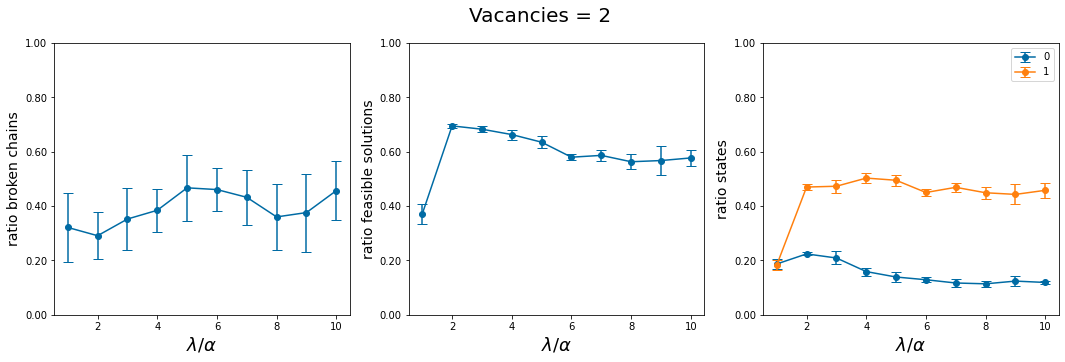

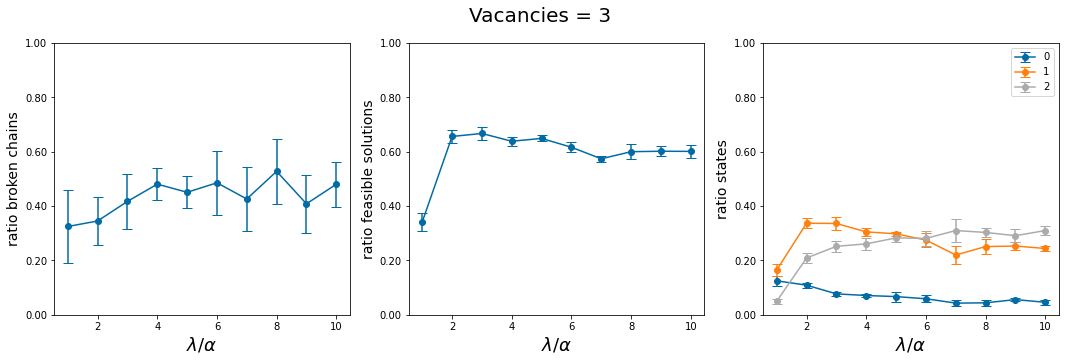

In [35]:
import matplotlib.pyplot as plt
np.seterr(divide='ignore')
plt.style.use('tableau-colorblind10')

df_results = make_df('./data/paper/convergence/')

num_runs = 1000
num_reads = 1000

for vac in [1,2,3]:    
    df_all = df_results[df_results['num_vacancies'] == vac]
    df_all = df_all[df_all['weight_1'] == 1.]
    df_mean = df_all[df_all['weight_1'] == 1.].groupby('ratio l/w').mean()
    fig, axs = plt.subplots(1,3,figsize=(18, 5), sharey=False)
    fig.suptitle('Vacancies = %s'%vac, fontsize=20)
    
    x = df_mean.index.values

    y1 = df_mean['broken_chains'].to_numpy()
    y2 = df_mean['ratio_feasible'].to_numpy()
    #y5 = df_mean['ratio_gs'].to_numpy()

    y3 = []
    y4 = []
    error_y3 = []
    error_y4 = []
    error_bc = []
    error_rf = []
    for n,k in enumerate(x):
        
        df_tmp = df_all[df_all['ratio l/w'] == k]
        
        energies = []
        for i in df_all['energy_distribution']:
            energies.extend([float(x) for x in i.split(',')])         
        all_energies = np.unique(np.array(energies))
        labels = [str(x) for x in range(len(all_energies))]
        dist_average = np.array([0]*len(all_energies))
        all_dist = []
        
        vacancies = []
        for i in df_all['vacancies']:
            vacancies.extend([float(x) for x in i.split(',')])         
        all_vacancies = np.unique(np.array(vacancies))
        labels_vac = [str(x) for x in range(len(all_vacancies))]
        dist_vac_average = np.array([0]*len(all_vacancies))
        all_vac = []
        
        error_bc.append(np.std(df_tmp['broken_chains'].to_numpy()))
        error_rf.append(np.std(df_tmp['ratio_feasible'].to_numpy()))
        for j in range(len(df_tmp['energy_distribution'].to_list())):
            distribution = []
            error = []
            #v_energy = np.array([float(x)/num_runs for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
            #v_mult = np.array([float(x)/num_runs for x in df_tmp['multiplicity'].to_list()[j].split(',')])
            for i in all_energies:
                v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
                v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
                pos = np.where(np.round(v_energy,5) == np.round(i,5))[0]
                
                if len(pos) > 0:
                    distribution.append(int(v_mult[pos[0]]))
                else:
                    distribution.append(0)
            all_dist.append(distribution) 
            
        y3.append(np.average(np.array(all_dist),axis=0).astype(int).tolist())
        
        error_y3.append(np.std(all_dist,axis=0))
        for j in range(len(df_tmp['vacancies'].to_list())):
            vacancies = []
            error = []
            v_vacancies = np.array([float(x) for x in df_tmp['vacancies'].to_list()[j].split(',')])
            v_vac_mult = np.array([float(x) for x in df_tmp['vacancies mult'].to_list()[j].split(',')])
            
            for i in all_vacancies:
                pos = np.where(np.round(v_vacancies,5) == np.round(i,5))[0]
                if len(pos) > 0:
                    
                    vacancies.append(int(v_vac_mult[pos[0]]))
                else:
                    vacancies.append(0)
            all_vac.append(vacancies) 
        y4.append(np.average(np.array(all_vac),axis=0).astype(int).tolist())
        error_y4.append(np.std(all_vac,axis=0))
    y3 = np.array(y3)/num_reads
    error_y3 = np.array(error_y3)/num_reads
    y4 = np.array(y4)

    # Normalise wrt the vacancy ( y =1 for vacancy = 1 for all values of x)
    y4 = y4/np.array(np.array([y4[:,np.where(all_vacancies == vac)[0]]]*y4.shape[1]).transpose()[0])

    # Normalise wrt the multiplicity of states
    #y4 = y4/partition_f[:y4.shape[1]]
    
    error_y4 = np.array(error_y4)
    error_y4 = error_y4/np.array(np.array([y4[:,np.where(all_vacancies == vac)[0]]]*y4.shape[1]).transpose()[0])
    ##error_y4 = error_y4/np.array(np.array([error_y4[:,vac]]*error_y4.shape[1]).transpose())
    #error_y4 = error_y4/partition_f[:y4.shape[1]]
    
    for m in range(len(y3[0])):
        axs[2].errorbar(x,y3[:,m],yerr=error_y3[:,m]/2,fmt='-o',label=labels[m],capsize=5)
    
    #for m in range(len(y4[0])):
        #axs[3].errorbar(x,y4[:,m],yerr=error_y4[:,m]/2,fmt='-o',color=color[m],label=int(all_vacancies[m]),capsize=5)
        #axs[3].plot(x,y4[:,m],'-o',label=int(all_vacancies[m]))

    axs[2].legend()
    #axs[3].legend()

    #axs[0].plot(x, y1,'-o')
    axs[0].errorbar(x, y1, yerr = np.array(error_bc)/2,fmt='-o',capsize=5)
    axs[1].errorbar(x, y2,yerr = np.array(error_rf)/2,fmt='-o',capsize=5)
    
    #axs[4].plot(x,y5,'-o')


    
    axs[0].set_ylabel('ratio broken chains', fontsize=14)
    axs[1].set_ylabel('ratio feasible solutions', fontsize=14)
    axs[2].set_ylabel('ratio states', fontsize=14)
    #axs[3].set_ylabel('ratio vacancies', fontsize=14)
    #axs[4].set_ylabel('ratio gs', fontsize=14)
    
    for i in range(3):
        axs[i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
        axs[i].xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
        axs[i].set_xlabel(r'$\lambda / \alpha$', fontsize=18)
        axs[i].set_ylim([0, 1])
    #fig.set_title('All feasible',fontsize=20)

#axs[:].set_xticks(np.arange(0,25))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

#fig.set_size_inches(15.5, 7.5)

    plt.show()
    fig.savefig('./data/images/alpha_gamma_graphs_%s.png'%str(vac),dpi=200)

### chain strength - uniform torque compensation

In [52]:
a = np.round(df_all['chain_strength'].to_numpy(dtype=float),5)


array([11.09009,  4.75289, 14.25868,  1.5843 ,  1.5843 , 14.25868,
       15.84298, 12.67438,  3.1686 ,  7.92149, 15.84298,  4.75289,
        7.92149,  3.1686 ,  7.92149, 11.09009,  3.1686 ,  4.75289,
        4.75289,  6.33719,  9.50579,  4.75289,  4.75289,  9.50579,
       15.84298,  1.5843 ,  1.5843 ,  4.75289,  4.75289, 11.09009,
        7.92149, 12.67438,  3.1686 ,  4.75289, 12.67438,  4.75289,
        1.5843 ,  6.33719, 11.09009,  6.33719,  3.1686 ,  6.33719,
        6.33719,  1.5843 , 12.67438, 15.84298,  9.50579,  4.75289,
        4.75289,  7.92149,  4.75289,  4.75289, 11.09009,  4.75289,
       15.84298, 15.84298,  7.92149,  6.33719,  9.50579, 12.67438,
       14.25868,  4.75289, 15.84298,  6.33719,  7.92149,  4.75289,
       15.84298,  4.75289,  9.50579, 14.25868,  4.75289,  1.5843 ,
       14.25868,  9.50579, 14.25868,  3.1686 , 14.25868, 14.25868,
        3.1686 ,  4.75289, 11.09009, 12.67438,  3.1686 , 12.67438,
        9.50579,  4.75289,  7.92149, 15.84298, 11.09009,  7.92

In [53]:
df_all['chain_strength'] = np.round(df_all['chain_strength'].to_numpy(dtype=float),5)

[ 1.5843   3.1686   4.75289  6.33719  7.92149  9.50579 11.09009 12.67438
 14.25868 15.84298]


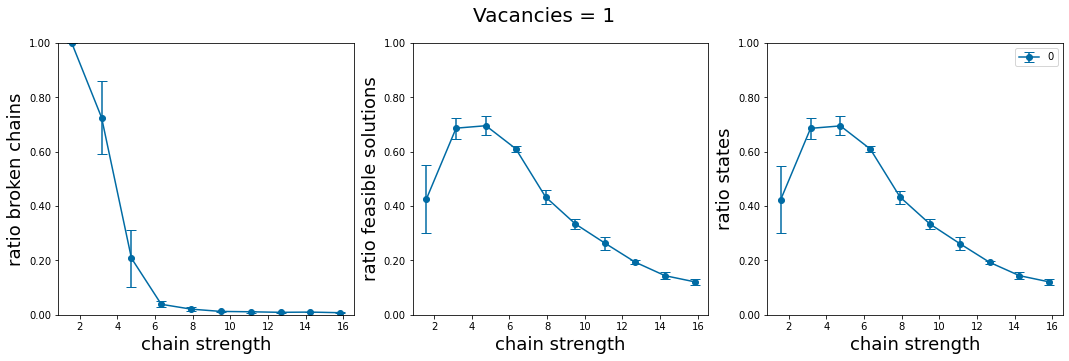

[ 1.5843   3.1686   4.75289  6.33719  7.92149  9.50579 11.09009 12.67438
 14.25868 15.84298]


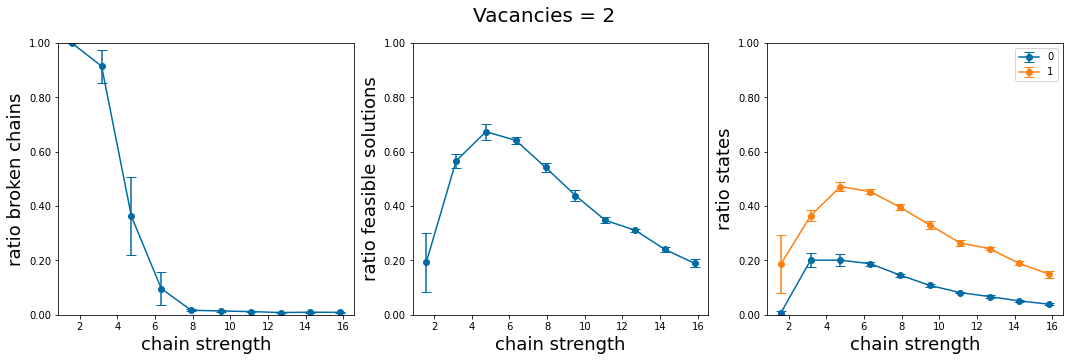

[ 1.5843   3.1686   4.75289  6.33719  7.92149  9.50579 11.09009 12.67438
 14.25868 15.84298]


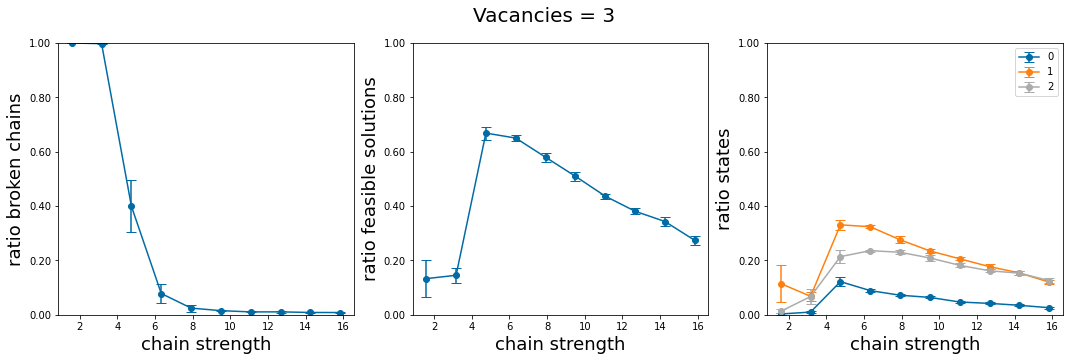

In [65]:
#FEASIBLE
import matplotlib.pyplot as plt

color = ['b','g','r','c','m','y','k','tab:orange',]
point = ['-o','^','s']

plt.style.use('tableau-colorblind10')

df_results = make_df('./data/paper/convergence/chain_strength/')

df_results.index = [int(x) for x in np.arange(len(df_results.index))]
np.where(df_results['energy_distribution'] == '')
df_results.drop(index=np.where(df_results['energy_distribution'] == '')[0], inplace=True)

for vac in [1,2,3]:
    df_all = df_results[df_results['num_vacancies'] == vac]
    df_all = df_all[df_all['weight_1'] == 1]
    df_all['chain_strength'] = np.round(df_all['chain_strength'].to_numpy(dtype=float),5)
    df_mean = df_all[df_all['weight_1'] == 1].groupby('chain_strength').mean()
    fig, axs = plt.subplots(1,3,figsize=(18, 5), sharey=False)
    fig.suptitle('Vacancies = %s'%vac, fontsize=20)
    
    x = df_mean.index.values

    y1 = df_mean['broken_chains'].to_numpy()
    y2 = df_mean['ratio_feasible'].to_numpy()

    y3 = []
    y4 = []
    error_y3 = []
    error_y4 = []
    error_bc = []
    error_rf = []
    for n,k in enumerate(x):
        df_tmp = df_all[df_all['chain_strength'] == k]
        energies = []
        for i in df_all['energy_distribution']:
            if i != '':
                energies.extend([float(x) for x in i.split(',')])         
        all_energies = np.unique(np.array(energies))
        labels = [str(x) for x in range(len(all_energies))]
        dist_average = np.array([0]*len(all_energies))
        all_dist = []
        
        vacancies = []
        for i in df_all['vacancies']:
            vacancies.extend([float(x) for x in i.split(',')])         
        all_vacancies = np.unique(np.array(vacancies))
        labels_vac = [str(x) for x in range(len(all_vacancies))]
        dist_vac_average = np.array([0]*len(all_vacancies))
        all_vac = []
        
        error_bc.append(np.std(df_tmp['broken_chains'].to_numpy()))
        error_rf.append(np.std(df_tmp['ratio_feasible'].to_numpy()))
        for j in range(len(df_tmp['energy_distribution'].to_list())):
            distribution = []
            error = []
            v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
            v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
            for i in all_energies:
                v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
                v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
                pos = np.where(np.round(v_energy,5) == np.round(i,5))[0]
                if len(pos) > 0:
                    distribution.append(int(v_mult[pos[0]]))
                else:
                    distribution.append(0)
            all_dist.append(distribution) 
        y3.append(np.average(np.array(all_dist),axis=0).astype(int).tolist())
        
        error_y3.append(np.std(all_dist,axis=0))

        '''for j in range(len(df_tmp['vacancies'].to_list())):
            vacancies = []
            error = []
            v_vacancies = np.array([float(x) for x in df_tmp['vacancies'].to_list()[j].split(',')])
            v_vac_mult = np.array([float(x) for x in df_tmp['vacancies mult'].to_list()[j].split(',')])
            
            for i in all_vacancies:
                pos = np.where(np.round(v_vacancies,5) == np.round(i,5))[0]
                if len(pos) > 0:
                    vacancies.append(int(v_vac_mult[pos[0]]))
                else:
                    vacancies.append(0)
            all_vac.append(vacancies) 
        y4.append(np.average(np.array(all_vac),axis=0).astype(int).tolist())
        error_y4.append(np.std(all_vac,axis=0))'''
    y3 = np.array(y3)/num_reads
    error_y3 = np.array(error_y3)/num_reads
    #y4 = np.array(y4)

    # Normalise wrt the vacancy ( y =1 for vacancy = 1 for all values of x)
    #y4 = y4/np.array(np.array([y4[:,np.where(all_vacancies == vac)[0]]]*y4.shape[1]).transpose()[0])

    # Normalise wrt the multiplicity of states
    #y4 = y4/partition_f[:y4.shape[1]]
    
    #error_y4 = np.array(error_y4)
    #error_y4 = error_y4/np.array(np.array([y4[:,np.where(all_vacancies == vac)[0]]]*y4.shape[1]).transpose()[0])
    ##error_y4 = error_y4/np.array(np.array([error_y4[:,vac]]*error_y4.shape[1]).transpose())
    #error_y4 = error_y4/partition_f[:y4.shape[1]]
    
    for m in range(len(y3[0])):
        axs[2].errorbar(x,y3[:,m],yerr=error_y3[:,m]/2,fmt='-o',label=labels[m],capsize=5)
    
    '''for m in range(len(y4[0])):
        #axs[3].errorbar(x,y4[:,m],yerr=error_y4[:,m]/2,fmt='-o',color=color[m],label=int(all_vacancies[m]),capsize=5)
        axs[3].plot(x,y4[:,m],'-o',label=int(all_vacancies[m]))
'''
    axs[2].legend()
    #axs[3].legend()

    #axs[0].plot(x, y1,'-o')
    axs[0].errorbar(x, y1, yerr = np.array(error_bc)/2,fmt='-o',capsize=5)
    axs[1].errorbar(x, y2,yerr = np.array(error_rf)/2,fmt='-o',capsize=5)

    axs[0].set_xlabel('chain strength', fontsize=18)
    axs[1].set_xlabel('chain strength', fontsize=18)
    axs[2].set_xlabel('chain strength', fontsize=18)
    #axs[3].set_xlabel('chain strength', fontsize=20)
    axs[0].set_ylabel('ratio broken chains', fontsize=18)
    axs[1].set_ylabel('ratio feasible solutions', fontsize=18)
    axs[2].set_ylabel('ratio states', fontsize=18)
    for i in range(3):
        axs[i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
        axs[i].xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
        axs[i].set_xlabel('chain strength', fontsize=18)
        axs[i].set_ylim([0, 1])
    plt.show()
    fig.savefig('./data/images/chain_strength_graphs_%s.png'%str(vac),dpi=200)
plt.show()

# anneal time

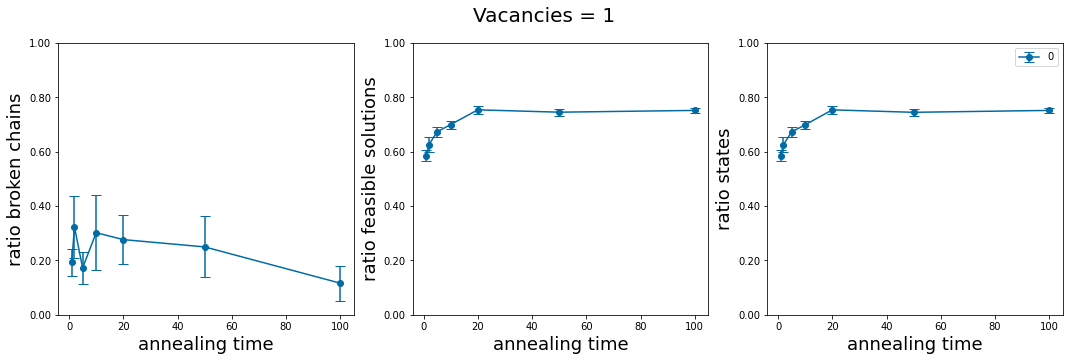

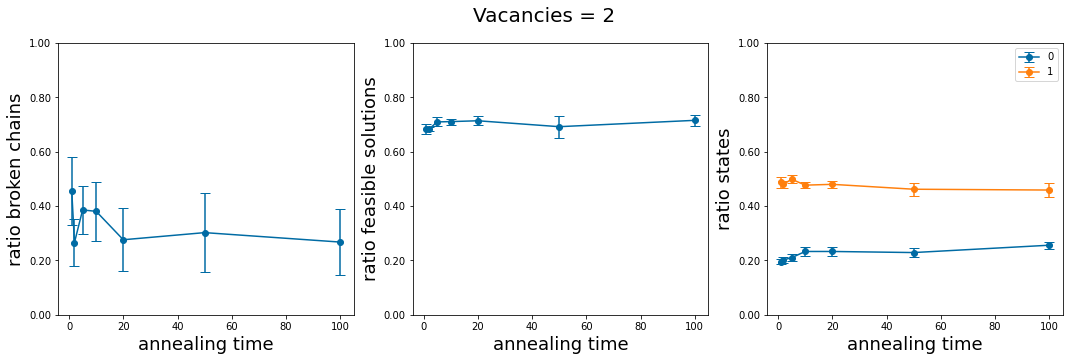

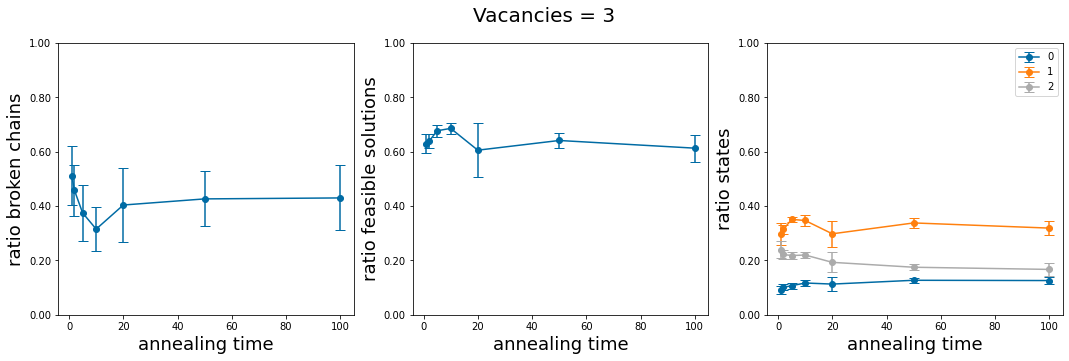

In [67]:
#FEASIBLE
import matplotlib.pyplot as plt

color = ['b','g','r','c','m','y','k','tab:orange',]
point = ['-o','^','s']

plt.style.use('tableau-colorblind10')

df_results = make_df('./data/paper/convergence/anneal_time/')

for vac in [1,2,3]:
    df_all = df_results[df_results['num_vacancies'] == vac]
    df_all = df_all[df_all['weight_1'] == 1]
    df_mean = df_all[df_all['weight_1'] == 1].groupby('qpu_anneal_time_per_sample').mean()
    fig, axs = plt.subplots(1,3,figsize=(18, 5), sharey=False)
    fig.suptitle('Vacancies = %s'%vac, fontsize=20)
    
    x = df_mean.index.values

    y1 = df_mean['broken_chains'].to_numpy()
    y2 = df_mean['ratio_feasible'].to_numpy()

    y3 = []
    y4 = []
    error_y3 = []
    error_y4 = []
    error_bc = []
    error_rf = []
    for n,k in enumerate(x):
        df_tmp = df_all[df_all['qpu_anneal_time_per_sample'] == k]
        energies = []
        for i in df_all['energy_distribution']:
            energies.extend([float(x) for x in i.split(',')])         
        all_energies = np.unique(np.array(energies))
        labels = [str(x) for x in range(len(all_energies))]
        dist_average = np.array([0]*len(all_energies))
        all_dist = []
        
        vacancies = []
        for i in df_all['vacancies']:
            vacancies.extend([float(x) for x in i.split(',')])         
        all_vacancies = np.unique(np.array(vacancies))
        labels_vac = [str(x) for x in range(len(all_vacancies))]
        dist_vac_average = np.array([0]*len(all_vacancies))
        all_vac = []
        
        error_bc.append(np.std(df_tmp['broken_chains'].to_numpy()))
        error_rf.append(np.std(df_tmp['ratio_feasible'].to_numpy()))
        for j in range(len(df_tmp['energy_distribution'].to_list())):
            distribution = []
            error = []
            v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
            v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
            for i in all_energies:
                v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
                v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
                pos = np.where(np.round(v_energy,5) == np.round(i,5))[0]
                if len(pos) > 0:
                    distribution.append(int(v_mult[pos[0]]))
                else:
                    distribution.append(0)
            all_dist.append(distribution) 
        y3.append(np.average(np.array(all_dist),axis=0).astype(int).tolist())
        
        error_y3.append(np.std(all_dist,axis=0))
        '''for j in range(len(df_tmp['vacancies'].to_list())):
            vacancies = []
            error = []
            v_vacancies = np.array([float(x) for x in df_tmp['vacancies'].to_list()[j].split(',')])
            v_vac_mult = np.array([float(x) for x in df_tmp['vacancies mult'].to_list()[j].split(',')])
            
            for i in all_vacancies:
                pos = np.where(np.round(v_vacancies,5) == np.round(i,5))[0]
                if len(pos) > 0:
                    vacancies.append(int(v_vac_mult[pos[0]]))
                else:
                    vacancies.append(0)
            all_vac.append(vacancies) 
        y4.append(np.average(np.array(all_vac),axis=0).astype(int).tolist())
        error_y4.append(np.std(all_vac,axis=0))'''
    y3 = np.array(y3)/num_reads
    error_y3 = np.array(error_y3)/num_reads
    #y4 = np.array(y4)

    # Normalise wrt the vacancy ( y =1 for vacancy = 1 for all values of x)
    #y4 = y4/np.array(np.array([y4[:,np.where(all_vacancies == vac)[0]]]*y4.shape[1]).transpose()[0])

    # Normalise wrt the multiplicity of states
    #y4 = y4/partition_f[:y4.shape[1]]
    
    #error_y4 = np.array(error_y4)
    #error_y4 = error_y4/np.array(np.array([y4[:,np.where(all_vacancies == vac)[0]]]*y4.shape[1]).transpose()[0])
    ##error_y4 = error_y4/np.array(np.array([error_y4[:,vac]]*error_y4.shape[1]).transpose())
    #error_y4 = error_y4/partition_f[:y4.shape[1]]
    
    for m in range(len(y3[0])):
        axs[2].errorbar(x,y3[:,m],yerr=error_y3[:,m]/2,fmt='-o',label=labels[m],capsize=5)
    
    '''for m in range(len(y4[0])):
        #axs[3].errorbar(x,y4[:,m],yerr=error_y4[:,m]/2,fmt='-o',color=color[m],label=int(all_vacancies[m]),capsize=5)
        axs[3].plot(x,y4[:,m],'-o',label=int(all_vacancies[m]))'''

    axs[2].legend()
    #axs[3].legend()

    #axs[0].plot(x, y1,'-o')
    axs[0].errorbar(x, y1, yerr = np.array(error_bc)/2,fmt='-o',capsize=5)
    axs[1].errorbar(x, y2,yerr = np.array(error_rf)/2,fmt='-o',capsize=5)

    axs[0].set_xlabel('annealing time', fontsize=18)
    axs[1].set_xlabel('annealing time', fontsize=18)
    axs[2].set_xlabel('annealing time', fontsize=18)
    #axs[3].set_xlabel('annealing time', fontsize=20)
    axs[0].set_ylabel('ratio broken chains', fontsize=18)
    axs[1].set_ylabel('ratio feasible solutions', fontsize=18)
    axs[2].set_ylabel('ratio states', fontsize=18)
    for i in range(3):
        axs[i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
        axs[i].xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
        axs[i].set_xlabel('annealing time', fontsize=18)
        axs[i].set_ylim([0, 1])
    fig.savefig('./data/images/anneal_time_graphs_%s.png'%str(vac),dpi=200)


plt.show()

# Compare with DFT

In [114]:
pd.read_json('./data/paper/dataframe_all.json')
#ddf_index = ['A', 'A', 'A', 'B', 'C', 'D', 'E', 'A', 'B', 'C', 'D', 'E', 'F', 'G',
       #'H', 'I', 'J', 'K', 'L', 'M', 'N']

,index,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,% broken chains,Energy,% occurence
0,A,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.000000,-27.00,100.0
1,A,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,2.222222,-24.00,67.0
2,A,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1.085714,-19.90,24.8
3,B,0,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,3.425000,-18.90,8.6
4,C,0,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1.165625,-18.90,12.2
5,D,0,1,1,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1.233333,-18.90,1.7
6,E,0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,2.269811,-18.85,27.3
7,A,0,1,1,0,1,1,1,1,1,...,1,1,1,1,1,1,1,0.602941,-18.15,6.7
8,B,0,1,1,1,1,1,1,0,1,...,1,1,1,1,0,1,1,0.393939,-17.20,5.2
9,C,0,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,0,0.560000,-17.20,2.3


In [7]:
import os
folder = './data/paper/crystal/scf/'
output_files = []
for file in os.listdir(folder):
    filename = os.fsdecode(file)
    if filename.endswith(".out"):
        output_files.append(filename)
output_files.sort()

scf_energy = []
scf_energy_dict = {}

for file in output_files:
    file_name = folder+file
    crystal_output = Crystal_output().read_cry_output(file_name)
    scf_energy.append(crystal_output.get_final_energy())
    scf_energy_dict[file] = [crystal_output.get_final_energy()]
    
scf_energy_arr = np.array(scf_energy)
scf_energy_arr[0] = scf_energy_arr[0]/scf_energy_arr[0]
scf_energy_arr[1] = scf_energy_arr[1]/scf_energy_arr[1]
scf_energy_arr[2:7] = scf_energy_arr[2:7]-scf_energy_arr[2]
scf_energy_arr[7:] = scf_energy_arr[7:]-scf_energy_arr[7]

df_scf = pd.DataFrame.from_dict(scf_energy_dict).transpose()


In [6]:
scf_energy_arr

array([ 1.        ,  1.        ,  0.        ,  6.95921127,  5.5815352 ,
        4.36682285,  4.47049   ,  0.        ,  4.09134161,  3.73570913,
        4.54897252,  3.54239683,  9.73388154,  9.16340194,  9.66857785,
        7.01556951,  9.00599277,  7.48478042, 12.54690364,  8.57684634,
        7.81402725])

In [8]:
df_scf['Delta'] = scf_energy_arr

In [118]:
df_scf

,0,Delta
graphene_0v_0.out,-18651.511290,1.000000
graphene_1v_A.out,-17607.074131,1.000000
graphene_2v_A.out,-16569.391487,0.000000
graphene_2v_B.out,-16562.432275,6.959211
graphene_2v_C.out,-16563.809951,5.581535
graphene_2v_D.out,-16565.024664,4.366823
graphene_2v_E.out,-16564.920997,4.470490
graphene_3v_A.out,-15530.148228,0.000000
graphene_3v_B.out,-15526.056887,4.091342
graphene_3v_C.out,-15526.412519,3.735709
